Using TensorFlow backend.


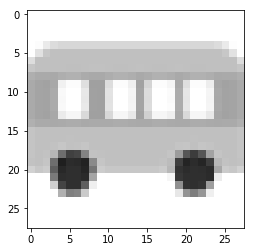

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)
plt.imshow(example_emoji);

In [3]:
import os
image_list = []
rootpath = 'C:\\Users\\lilyx\\DS-Unit-4-Sprint-3-Deep-Learning\\module3-generative-adversarial-networks\\emoji\\'
for filename in os.listdir(rootpath):
    filename = rootpath + filename
    image_list.append(filename)

In [4]:
# image_list

In [5]:
# image_list
from PIL import Image
import PIL.Image
import PIL.ImageOps

##Did not work
# def grayscale(filename):
#     image = imageio.imread(filename)
#     color.rgb2gray(image)
#     return image
# for i in image_list:
#     grayscale(i)

In [6]:
# # image_list
# def grayscale(filename):
#     image = Image.open(filename).convert('LA')
#     image.save(filename)
    
# for i in image_list:
#     grayscale(i)

In [7]:
# #gyscale_emoji

# for i in image_list:
#     grayscale(i)

In [8]:
# sample = imageio.imread(image_list[0])
# plt.imshow(sample, cmap=plt.get_cmap('gray'));

In [9]:
# sample.shape

In [10]:
# sample

In [11]:
from skimage import io
img_list = [color.rgb2gray(io.imread(i)) for i in image_list]

In [15]:
import numpy as np
img_list = np.array(img_list)
img_list.shape
# sample = imageio.imread(img_list[0])
# plt.imshow(sample, cmap="gray");

(860, 28, 28)

In [18]:
np.random.seed(10)
random_dim = 100
 
def transform_emojis():
    emoji_train = (img_list.astype(np.float32) - 127.5)/127.5
    # convert emoji_train with a shape of (861, 28, 28) to (861, 784) so we have
    # 784 columns per row
    emoji_train = emoji_train.reshape(860, 784)
    return emoji_train

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.2)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # initially set trainable to False since we only want to train either the 
    # generator or the discriminator at a time
    discriminator.trainable = False
    #gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (prob if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10,10),
                         figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_emoji_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=128):
    # Get the training emojis
    x_train = transform_emojis()
    batch_count = x_train.shape[0] // batch_size
    
    # build GAN network
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                size = batch_size)]
            # Generate fake emojis
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # one sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 1000 == 0:
            plot_generated_images(e, generator)

 
train(5000, 64)

W0824 14:43:04.334023 14460 deprecation_wrapper.py:119] From C:\Users\lilyx\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 14:43:04.337031 14460 deprecation_wrapper.py:119] From C:\Users\lilyx\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 14:43:04.340027 14460 deprecation_wrapper.py:119] From C:\Users\lilyx\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0824 14:43:04.360026 14460 deprecation_wrapper.py:119] From C:\Users\lilyx\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 14:43:04.404026 14460 deprecation_wrapper.py:119] From C:\Users\lilyx\A

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  2.94it/s]


--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 11 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 12 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 13 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 14 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 15 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 16 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 17 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 18 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 19 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 20 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.16it/s]


--------------- Epoch 21 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.56it/s]


--------------- Epoch 22 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 23 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.46it/s]


--------------- Epoch 24 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 25 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.23it/s]


--------------- Epoch 26 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 27 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 28 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 29 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.56it/s]


--------------- Epoch 30 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 31 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 32 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 33 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 34 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 35 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.11it/s]


--------------- Epoch 36 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 37 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.92it/s]


--------------- Epoch 38 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


--------------- Epoch 39 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 40 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 41 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 42 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 43 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 44 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 45 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 46 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 47 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 48 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 49 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 50 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 51 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 52 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 53 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 54 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 55 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 56 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 57 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 58 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 59 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 60 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 61 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.66it/s]


--------------- Epoch 62 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 63 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.15it/s]


--------------- Epoch 64 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.40it/s]


--------------- Epoch 65 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.68it/s]


--------------- Epoch 66 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.32it/s]


--------------- Epoch 67 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 68 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.47it/s]


--------------- Epoch 69 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.17it/s]


--------------- Epoch 70 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.66it/s]


--------------- Epoch 71 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.67it/s]


--------------- Epoch 72 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.47it/s]


--------------- Epoch 73 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 74 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.09it/s]


--------------- Epoch 75 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 76 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.22it/s]


--------------- Epoch 77 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.59it/s]


--------------- Epoch 78 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.40it/s]


--------------- Epoch 79 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.12it/s]


--------------- Epoch 80 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.78it/s]


--------------- Epoch 81 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.21it/s]


--------------- Epoch 82 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.49it/s]


--------------- Epoch 83 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 84 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.11it/s]


--------------- Epoch 85 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.52it/s]


--------------- Epoch 86 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 87 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.23it/s]


--------------- Epoch 88 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 89 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 90 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 91 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 92 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 93 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 94 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.75it/s]


--------------- Epoch 95 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.41it/s]


--------------- Epoch 96 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.37it/s]


--------------- Epoch 97 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.41it/s]


--------------- Epoch 98 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 99 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 100 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 101 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 102 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 103 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 104 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.53it/s]


--------------- Epoch 105 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 106 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 107 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 108 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 109 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


--------------- Epoch 110 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 111 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 112 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 113 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.00it/s]


--------------- Epoch 114 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 115 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 116 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 117 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 118 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 119 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 120 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 121 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 122 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 123 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 124 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 125 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 126 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 127 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 128 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 129 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 130 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 131 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 132 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 133 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.21it/s]


--------------- Epoch 134 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.42it/s]


--------------- Epoch 135 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.00it/s]


--------------- Epoch 136 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.04it/s]


--------------- Epoch 137 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 138 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.61it/s]


--------------- Epoch 139 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 140 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 141 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.03it/s]


--------------- Epoch 142 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.33it/s]


--------------- Epoch 143 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.17it/s]


--------------- Epoch 144 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 145 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 146 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.32it/s]


--------------- Epoch 147 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.97it/s]


--------------- Epoch 148 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.46it/s]


--------------- Epoch 149 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.00it/s]


--------------- Epoch 150 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.19it/s]


--------------- Epoch 151 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 152 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 153 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 154 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.82it/s]


--------------- Epoch 155 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 156 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 157 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 158 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 159 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 160 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 161 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 162 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 163 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 164 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 165 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 166 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 167 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 168 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 169 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.21it/s]


--------------- Epoch 170 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 171 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 172 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 173 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 174 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 175 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 176 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 177 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 178 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 179 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.10it/s]


--------------- Epoch 180 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 181 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 182 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 183 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 184 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 185 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 186 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 187 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 188 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 189 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 190 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 191 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.68it/s]


--------------- Epoch 192 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 193 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 194 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 195 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.39it/s]


--------------- Epoch 196 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 197 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


--------------- Epoch 198 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 199 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 200 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 201 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 202 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.43it/s]


--------------- Epoch 203 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 204 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.10it/s]


--------------- Epoch 205 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 206 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 207 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 208 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 209 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 210 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 211 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 212 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 213 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 214 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 215 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 216 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 217 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 218 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 219 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 220 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 221 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 222 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 223 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 224 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 225 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.50it/s]


--------------- Epoch 226 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 227 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 228 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 229 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 230 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 231 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


--------------- Epoch 232 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 233 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 234 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 235 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 236 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.80it/s]


--------------- Epoch 237 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 238 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 239 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 240 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 241 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.10it/s]


--------------- Epoch 242 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 243 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 244 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.32it/s]


--------------- Epoch 245 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 246 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 247 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 248 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 249 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 250 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


--------------- Epoch 251 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 252 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.52it/s]


--------------- Epoch 253 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 254 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 255 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 256 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.23it/s]


--------------- Epoch 257 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.79it/s]


--------------- Epoch 258 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 259 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 260 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 261 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 262 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 263 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 264 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.95it/s]


--------------- Epoch 265 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.57it/s]


--------------- Epoch 266 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 267 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 268 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.89it/s]


--------------- Epoch 269 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.59it/s]


--------------- Epoch 270 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.13it/s]


--------------- Epoch 271 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.08it/s]


--------------- Epoch 272 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 273 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 274 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 275 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 276 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.05it/s]


--------------- Epoch 277 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.79it/s]


--------------- Epoch 278 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 279 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.06it/s]


--------------- Epoch 280 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.71it/s]


--------------- Epoch 281 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.83it/s]


--------------- Epoch 282 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.27it/s]


--------------- Epoch 283 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.37it/s]


--------------- Epoch 284 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 285 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.96it/s]


--------------- Epoch 286 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 287 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.95it/s]


--------------- Epoch 288 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.06it/s]


--------------- Epoch 289 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.74it/s]


--------------- Epoch 290 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.00it/s]


--------------- Epoch 291 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 292 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.38it/s]


--------------- Epoch 293 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 294 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 295 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.83it/s]


--------------- Epoch 296 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.81it/s]


--------------- Epoch 297 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.41it/s]


--------------- Epoch 298 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 299 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.40it/s]


--------------- Epoch 300 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 301 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.99it/s]


--------------- Epoch 302 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.29it/s]


--------------- Epoch 303 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.50it/s]


--------------- Epoch 304 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.29it/s]


--------------- Epoch 305 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.40it/s]


--------------- Epoch 306 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.50it/s]


--------------- Epoch 307 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.64it/s]


--------------- Epoch 308 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.83it/s]


--------------- Epoch 309 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.70it/s]


--------------- Epoch 310 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.21it/s]


--------------- Epoch 311 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.42it/s]


--------------- Epoch 312 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 313 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.14it/s]


--------------- Epoch 314 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.59it/s]


--------------- Epoch 315 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.54it/s]


--------------- Epoch 316 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.12it/s]


--------------- Epoch 317 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.22it/s]


--------------- Epoch 318 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.66it/s]


--------------- Epoch 319 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.00it/s]


--------------- Epoch 320 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 321 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 322 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.85it/s]


--------------- Epoch 323 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.96it/s]


--------------- Epoch 324 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.71it/s]


--------------- Epoch 325 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.00it/s]


--------------- Epoch 326 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.50it/s]


--------------- Epoch 327 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.45it/s]


--------------- Epoch 328 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.95it/s]


--------------- Epoch 329 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 330 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 331 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.55it/s]


--------------- Epoch 332 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 333 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.75it/s]


--------------- Epoch 334 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.01it/s]


--------------- Epoch 335 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.22it/s]


--------------- Epoch 336 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.94it/s]


--------------- Epoch 337 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 338 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.90it/s]


--------------- Epoch 339 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 340 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 341 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.89it/s]


--------------- Epoch 342 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.07it/s]


--------------- Epoch 343 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.00it/s]


--------------- Epoch 344 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 345 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 346 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.41it/s]


--------------- Epoch 347 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 348 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 349 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.35it/s]


--------------- Epoch 350 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 351 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.93it/s]


--------------- Epoch 352 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 353 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.16it/s]


--------------- Epoch 354 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.09it/s]


--------------- Epoch 355 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 356 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.55it/s]


--------------- Epoch 357 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.53it/s]


--------------- Epoch 358 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.78it/s]


--------------- Epoch 359 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.41it/s]


--------------- Epoch 360 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.21it/s]


--------------- Epoch 361 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.45it/s]


--------------- Epoch 362 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 363 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.20it/s]


--------------- Epoch 364 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.31it/s]


--------------- Epoch 365 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.80it/s]


--------------- Epoch 366 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.17it/s]


--------------- Epoch 367 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.24it/s]


--------------- Epoch 368 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.09it/s]


--------------- Epoch 369 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 370 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.17it/s]


--------------- Epoch 371 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 372 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 373 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 374 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.30it/s]


--------------- Epoch 375 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 376 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 377 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 378 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 379 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


--------------- Epoch 380 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 381 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.25it/s]


--------------- Epoch 382 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 383 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 384 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 385 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 386 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


--------------- Epoch 387 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.85it/s]


--------------- Epoch 388 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 389 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 390 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 391 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 392 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 393 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 394 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 395 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 396 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.30it/s]


--------------- Epoch 397 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 398 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 399 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.65it/s]


--------------- Epoch 400 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.80it/s]


--------------- Epoch 401 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.16it/s]


--------------- Epoch 402 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 403 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 404 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 405 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 406 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 407 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 408 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 409 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.80it/s]


--------------- Epoch 410 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.41it/s]


--------------- Epoch 411 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 412 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 413 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 414 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 415 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 416 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


--------------- Epoch 417 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 418 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 419 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 420 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 421 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.73it/s]


--------------- Epoch 422 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 423 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 424 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 425 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 426 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 427 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 428 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 429 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 430 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 431 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 432 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.11it/s]


--------------- Epoch 433 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 434 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 435 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 436 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 437 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 438 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.58it/s]


--------------- Epoch 439 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 440 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 441 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 442 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 443 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 444 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 445 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 446 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 447 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 448 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 449 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.30it/s]


--------------- Epoch 450 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 451 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 452 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 453 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 454 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.41it/s]


--------------- Epoch 455 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 456 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 457 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 458 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.19it/s]


--------------- Epoch 459 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 460 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 461 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.51it/s]


--------------- Epoch 462 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.67it/s]


--------------- Epoch 463 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 464 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 465 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 466 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 467 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 468 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.79it/s]


--------------- Epoch 469 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 470 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 471 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 472 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 473 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.15it/s]


--------------- Epoch 474 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 475 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 476 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 477 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]


--------------- Epoch 478 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 479 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 480 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 481 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 482 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 483 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 484 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 485 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 486 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.60it/s]


--------------- Epoch 487 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 488 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 489 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 490 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 491 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.93it/s]


--------------- Epoch 492 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.09it/s]


--------------- Epoch 493 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 494 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 495 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 496 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 497 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 498 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 499 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 500 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 501 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 502 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


--------------- Epoch 503 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.08it/s]


--------------- Epoch 504 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 505 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


--------------- Epoch 506 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 507 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 508 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 509 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 510 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 511 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.33it/s]


--------------- Epoch 512 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 513 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 514 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 515 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 516 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 517 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


--------------- Epoch 518 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.11it/s]


--------------- Epoch 519 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.04it/s]


--------------- Epoch 520 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 521 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 522 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 523 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 524 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 525 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 526 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 527 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 528 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 529 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 530 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 531 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.62it/s]


--------------- Epoch 532 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 533 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


--------------- Epoch 534 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.93it/s]


--------------- Epoch 535 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.62it/s]


--------------- Epoch 536 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.88it/s]


--------------- Epoch 537 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 538 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 539 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 540 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.55it/s]


--------------- Epoch 541 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.79it/s]


--------------- Epoch 542 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 543 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.53it/s]


--------------- Epoch 544 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 545 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.81it/s]


--------------- Epoch 546 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 547 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 548 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 549 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 550 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 551 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 552 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 553 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 554 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.83it/s]


--------------- Epoch 555 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 556 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 557 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.36it/s]


--------------- Epoch 558 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.58it/s]


--------------- Epoch 559 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.33it/s]


--------------- Epoch 560 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.82it/s]


--------------- Epoch 561 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.91it/s]


--------------- Epoch 562 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 563 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 564 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 565 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.32it/s]


--------------- Epoch 566 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.09it/s]


--------------- Epoch 567 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.88it/s]


--------------- Epoch 568 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.00it/s]


--------------- Epoch 569 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.78it/s]


--------------- Epoch 570 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.56it/s]


--------------- Epoch 571 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 572 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.85it/s]


--------------- Epoch 573 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.74it/s]


--------------- Epoch 574 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 575 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.31it/s]


--------------- Epoch 576 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 577 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 578 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.84it/s]


--------------- Epoch 579 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.89it/s]


--------------- Epoch 580 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.49it/s]


--------------- Epoch 581 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.09it/s]


--------------- Epoch 582 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.15it/s]


--------------- Epoch 583 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 584 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 585 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 586 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 587 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.30it/s]


--------------- Epoch 588 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.35it/s]


--------------- Epoch 589 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.08it/s]


--------------- Epoch 590 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 591 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.71it/s]


--------------- Epoch 592 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.86it/s]


--------------- Epoch 593 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 594 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 595 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.11it/s]


--------------- Epoch 596 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.01it/s]


--------------- Epoch 597 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.94it/s]


--------------- Epoch 598 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.63it/s]


--------------- Epoch 599 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 600 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.04it/s]


--------------- Epoch 601 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.47it/s]


--------------- Epoch 602 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 603 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.90it/s]


--------------- Epoch 604 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.99it/s]


--------------- Epoch 605 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 606 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 607 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.87it/s]


--------------- Epoch 608 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.82it/s]


--------------- Epoch 609 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.24it/s]


--------------- Epoch 610 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.72it/s]


--------------- Epoch 611 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.14it/s]


--------------- Epoch 612 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 613 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 614 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.72it/s]


--------------- Epoch 615 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.89it/s]


--------------- Epoch 616 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 617 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.04it/s]


--------------- Epoch 618 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.00it/s]


--------------- Epoch 619 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.49it/s]


--------------- Epoch 620 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.54it/s]


--------------- Epoch 621 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.79it/s]


--------------- Epoch 622 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.11it/s]


--------------- Epoch 623 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.84it/s]


--------------- Epoch 624 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.86it/s]


--------------- Epoch 625 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 626 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.09it/s]


--------------- Epoch 627 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.20it/s]


--------------- Epoch 628 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.83it/s]


--------------- Epoch 629 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.87it/s]


--------------- Epoch 630 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.38it/s]


--------------- Epoch 631 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.61it/s]


--------------- Epoch 632 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.16it/s]


--------------- Epoch 633 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 634 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 635 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 636 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.12it/s]


--------------- Epoch 637 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.10it/s]


--------------- Epoch 638 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.15it/s]


--------------- Epoch 639 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.47it/s]


--------------- Epoch 640 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 641 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 642 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 643 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 644 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.44it/s]


--------------- Epoch 645 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.20it/s]


--------------- Epoch 646 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.14it/s]


--------------- Epoch 647 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 12.98it/s]


--------------- Epoch 648 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 649 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 650 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 651 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 652 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.56it/s]


--------------- Epoch 653 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.02it/s]


--------------- Epoch 654 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.41it/s]


--------------- Epoch 655 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 656 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.07it/s]


--------------- Epoch 657 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 658 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 659 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.78it/s]


--------------- Epoch 660 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 661 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 662 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 663 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 664 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 665 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 666 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 667 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 668 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.25it/s]


--------------- Epoch 669 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 670 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 671 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 672 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 673 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 674 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 675 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


--------------- Epoch 676 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 677 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 678 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 679 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.73it/s]


--------------- Epoch 680 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.12it/s]


--------------- Epoch 681 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 682 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 683 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 684 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 685 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 686 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 687 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 688 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 689 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 690 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 691 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 692 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 693 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 694 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 695 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.84it/s]


--------------- Epoch 696 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.00it/s]


--------------- Epoch 697 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 698 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 699 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 700 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 701 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 702 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 703 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 704 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.00it/s]


--------------- Epoch 705 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 706 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 707 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 708 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 709 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.90it/s]


--------------- Epoch 710 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 711 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


--------------- Epoch 712 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 713 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 714 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 715 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.41it/s]


--------------- Epoch 716 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 717 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 718 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 719 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 720 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 721 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 722 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 723 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 724 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.73it/s]


--------------- Epoch 725 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s]


--------------- Epoch 726 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.58it/s]


--------------- Epoch 727 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 728 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.54it/s]


--------------- Epoch 729 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 730 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.55it/s]


--------------- Epoch 731 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.57it/s]


--------------- Epoch 732 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 733 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 734 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 735 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.74it/s]


--------------- Epoch 736 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 737 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 738 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 739 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 740 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 741 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 742 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 743 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 744 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 745 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.73it/s]


--------------- Epoch 746 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 747 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.16it/s]


--------------- Epoch 748 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.50it/s]


--------------- Epoch 749 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 750 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 751 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 752 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 753 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.22it/s]


--------------- Epoch 754 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.32it/s]


--------------- Epoch 755 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 756 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 757 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 758 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 759 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 760 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 761 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 762 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 763 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 764 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.04it/s]


--------------- Epoch 765 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 766 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 767 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 768 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 769 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 770 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 771 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 772 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 773 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 774 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 775 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 776 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 777 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 778 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 779 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 780 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.50it/s]


--------------- Epoch 781 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.54it/s]


--------------- Epoch 782 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 783 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.39it/s]


--------------- Epoch 784 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 785 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 786 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.04it/s]


--------------- Epoch 787 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 788 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


--------------- Epoch 789 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 790 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.15it/s]


--------------- Epoch 791 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.24it/s]


--------------- Epoch 792 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


--------------- Epoch 793 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.76it/s]


--------------- Epoch 794 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 795 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 796 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 797 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 798 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.50it/s]


--------------- Epoch 799 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 800 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 801 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 802 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 803 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 804 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 805 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 806 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 807 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 808 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 809 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.50it/s]


--------------- Epoch 810 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.67it/s]


--------------- Epoch 811 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 812 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 813 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.60it/s]


--------------- Epoch 814 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 815 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 816 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 817 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 818 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 819 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 820 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.27it/s]


--------------- Epoch 821 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.72it/s]


--------------- Epoch 822 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.00it/s]


--------------- Epoch 823 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 824 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.25it/s]


--------------- Epoch 825 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 826 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 827 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 828 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 829 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 830 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 831 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 832 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.96it/s]


--------------- Epoch 833 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 834 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 835 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.40it/s]


--------------- Epoch 836 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 837 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 838 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 839 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 840 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


--------------- Epoch 841 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 842 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 843 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 844 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.08it/s]


--------------- Epoch 845 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 846 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 847 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 848 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 849 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 850 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.92it/s]


--------------- Epoch 851 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.95it/s]


--------------- Epoch 852 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.94it/s]


--------------- Epoch 853 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.82it/s]


--------------- Epoch 854 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.69it/s]


--------------- Epoch 855 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 856 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.56it/s]


--------------- Epoch 857 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 858 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.53it/s]


--------------- Epoch 859 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 860 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 861 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.31it/s]


--------------- Epoch 862 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 863 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 864 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 865 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 866 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 867 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 868 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


--------------- Epoch 869 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 870 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 871 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 872 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.04it/s]


--------------- Epoch 873 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 874 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 875 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 876 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 877 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 878 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 879 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 880 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 881 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 882 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 883 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.25it/s]


--------------- Epoch 884 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 885 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 886 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 887 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.09it/s]


--------------- Epoch 888 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.86it/s]


--------------- Epoch 889 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 890 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.83it/s]


--------------- Epoch 891 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.59it/s]


--------------- Epoch 892 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.13it/s]


--------------- Epoch 893 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 894 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 895 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 896 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 897 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 898 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 899 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 900 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s]


--------------- Epoch 901 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 902 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 903 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


--------------- Epoch 904 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.14it/s]


--------------- Epoch 905 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 906 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.32it/s]


--------------- Epoch 907 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 908 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 909 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.62it/s]


--------------- Epoch 910 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 911 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 912 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 913 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 914 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.50it/s]


--------------- Epoch 915 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.37it/s]


--------------- Epoch 916 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 917 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.67it/s]


--------------- Epoch 918 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.37it/s]


--------------- Epoch 919 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 920 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.78it/s]


--------------- Epoch 921 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.88it/s]


--------------- Epoch 922 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 923 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 924 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 925 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 926 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 927 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 928 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 929 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 930 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


--------------- Epoch 931 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 932 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.28it/s]


--------------- Epoch 933 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 934 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 935 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 936 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 937 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 938 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 939 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 940 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 941 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 942 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.43it/s]


--------------- Epoch 943 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 944 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 945 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.92it/s]


--------------- Epoch 946 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 947 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.91it/s]


--------------- Epoch 948 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 949 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.47it/s]


--------------- Epoch 950 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 951 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 952 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 953 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 954 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 955 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 956 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.50it/s]


--------------- Epoch 957 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 958 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s]


--------------- Epoch 959 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 960 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.34it/s]


--------------- Epoch 961 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 962 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.98it/s]


--------------- Epoch 963 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.41it/s]


--------------- Epoch 964 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 965 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.47it/s]


--------------- Epoch 966 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 967 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 968 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.20it/s]


--------------- Epoch 969 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 970 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.94it/s]


--------------- Epoch 971 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 972 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 973 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 974 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 975 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 976 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 977 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 978 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 979 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 980 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 981 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 982 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.94it/s]


--------------- Epoch 983 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 984 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.86it/s]


--------------- Epoch 985 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 986 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 987 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 988 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.73it/s]


--------------- Epoch 989 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 990 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 991 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.71it/s]


--------------- Epoch 992 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 993 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 994 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 995 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 996 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 997 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 998 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.65it/s]


--------------- Epoch 999 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 1000 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1001 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 1002 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1003 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1004 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 1005 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.16it/s]


--------------- Epoch 1006 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 1007 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 1008 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 1009 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 1010 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.73it/s]


--------------- Epoch 1011 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 1012 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 1013 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 1014 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1015 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 1016 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1017 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1018 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1019 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1020 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 1021 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1022 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 1023 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


--------------- Epoch 1024 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 1025 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1026 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.09it/s]


--------------- Epoch 1027 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1028 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 1029 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1030 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1031 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1032 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 1033 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1034 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1035 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 1036 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 1037 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.76it/s]


--------------- Epoch 1038 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 1039 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 1040 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.23it/s]


--------------- Epoch 1041 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.39it/s]


--------------- Epoch 1042 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.12it/s]


--------------- Epoch 1043 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 1044 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.96it/s]


--------------- Epoch 1045 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 1046 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.70it/s]


--------------- Epoch 1047 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 1048 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1049 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.50it/s]


--------------- Epoch 1050 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.18it/s]


--------------- Epoch 1051 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.12it/s]


--------------- Epoch 1052 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.79it/s]


--------------- Epoch 1053 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 1054 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.99it/s]


--------------- Epoch 1055 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 1056 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 1057 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.87it/s]


--------------- Epoch 1058 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 1059 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.28it/s]


--------------- Epoch 1060 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.70it/s]


--------------- Epoch 1061 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 1062 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 1063 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.01it/s]


--------------- Epoch 1064 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 1065 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 1066 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.21it/s]


--------------- Epoch 1067 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.97it/s]


--------------- Epoch 1068 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1069 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.14it/s]


--------------- Epoch 1070 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 1071 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 1072 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 1073 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 1074 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 1075 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1076 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 1077 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 1078 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1079 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


--------------- Epoch 1080 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 1081 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.10it/s]


--------------- Epoch 1082 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 1083 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 1084 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 1085 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 1086 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 1087 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.62it/s]


--------------- Epoch 1088 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 1089 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.63it/s]


--------------- Epoch 1090 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.01it/s]


--------------- Epoch 1091 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.23it/s]


--------------- Epoch 1092 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 1093 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.87it/s]


--------------- Epoch 1094 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.07it/s]


--------------- Epoch 1095 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.84it/s]


--------------- Epoch 1096 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1097 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 1098 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.53it/s]


--------------- Epoch 1099 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.05it/s]


--------------- Epoch 1100 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 1101 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.70it/s]


--------------- Epoch 1102 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 1103 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 1104 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.16it/s]


--------------- Epoch 1105 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 1106 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 1107 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 1108 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 1109 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 1110 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.00it/s]


--------------- Epoch 1111 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.17it/s]


--------------- Epoch 1112 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.10it/s]


--------------- Epoch 1113 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.21it/s]


--------------- Epoch 1114 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1115 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.85it/s]


--------------- Epoch 1116 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.85it/s]


--------------- Epoch 1117 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 1118 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1119 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 1120 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 1121 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.58it/s]


--------------- Epoch 1122 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 1123 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 1124 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.95it/s]


--------------- Epoch 1125 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1126 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1127 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 1128 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1129 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 1130 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.37it/s]


--------------- Epoch 1131 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 1132 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1133 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 1134 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 1135 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 1136 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


--------------- Epoch 1137 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 1138 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 1139 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 1140 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1141 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 1142 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 1143 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 1144 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


--------------- Epoch 1145 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 1146 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.07it/s]


--------------- Epoch 1147 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1148 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.45it/s]


--------------- Epoch 1149 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.86it/s]


--------------- Epoch 1150 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 1151 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 1152 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.98it/s]


--------------- Epoch 1153 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.96it/s]


--------------- Epoch 1154 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 1155 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 1156 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 1157 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 1158 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 1159 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 1160 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 1161 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1162 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 1163 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 1164 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 1165 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 1166 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1167 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.14it/s]


--------------- Epoch 1168 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1169 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 1170 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 1171 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 1172 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 1173 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 1174 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 1175 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 1176 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.62it/s]


--------------- Epoch 1177 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.45it/s]


--------------- Epoch 1178 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 1179 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 1180 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.84it/s]


--------------- Epoch 1181 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.08it/s]


--------------- Epoch 1182 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 1183 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1184 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 1185 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 1186 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1187 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 1188 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1189 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1190 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.39it/s]


--------------- Epoch 1191 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1192 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 1193 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1194 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1195 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 1196 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 1197 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 1198 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 1199 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1200 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1201 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 1202 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 1203 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 1204 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 1205 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1206 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 1207 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.04it/s]


--------------- Epoch 1208 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1209 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


--------------- Epoch 1210 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 1211 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 1212 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.30it/s]


--------------- Epoch 1213 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.90it/s]


--------------- Epoch 1214 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.54it/s]


--------------- Epoch 1215 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 1216 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 1217 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1218 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 1219 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 1220 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1221 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 1222 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1223 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.67it/s]


--------------- Epoch 1224 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 1225 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.84it/s]


--------------- Epoch 1226 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1227 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 1228 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1229 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1230 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1231 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 1232 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1233 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 1234 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 1235 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.41it/s]


--------------- Epoch 1236 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1237 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1238 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 1239 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1240 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.48it/s]


--------------- Epoch 1241 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1242 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 1243 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 1244 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1245 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 1246 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.52it/s]


--------------- Epoch 1247 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1248 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1249 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.34it/s]


--------------- Epoch 1250 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1251 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 1252 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 1253 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 1254 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 1255 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.28it/s]


--------------- Epoch 1256 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.74it/s]


--------------- Epoch 1257 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1258 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1259 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 1260 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 1261 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 1262 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 1263 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1264 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 1265 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1266 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 1267 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 1268 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 1269 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 1270 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 1271 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 1272 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1273 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 1274 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1275 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1276 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.25it/s]


--------------- Epoch 1277 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.02it/s]


--------------- Epoch 1278 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.65it/s]


--------------- Epoch 1279 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 1280 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 1281 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1282 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.18it/s]


--------------- Epoch 1283 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 1284 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 1285 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1286 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 1287 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 1288 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 1289 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 1290 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 1291 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1292 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 1293 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1294 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 1295 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.75it/s]


--------------- Epoch 1296 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 1297 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 1298 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 1299 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.71it/s]


--------------- Epoch 1300 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.43it/s]


--------------- Epoch 1301 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.00it/s]


--------------- Epoch 1302 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1303 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1304 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.34it/s]


--------------- Epoch 1305 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 1306 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1307 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 1308 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1309 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 1310 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 1311 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.02it/s]


--------------- Epoch 1312 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1313 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1314 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1315 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.96it/s]


--------------- Epoch 1316 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1317 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1318 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 1319 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 1320 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 1321 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 1322 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 1323 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 1324 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.75it/s]


--------------- Epoch 1325 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1326 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 1327 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 1328 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1329 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 1330 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 1331 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1332 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1333 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 1334 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 1335 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 1336 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 1337 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 1338 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1339 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1340 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 1341 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.70it/s]


--------------- Epoch 1342 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 1343 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 1344 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 1345 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 1346 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 1347 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1348 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 1349 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 1350 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 1351 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 1352 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 1353 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 1354 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 1355 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.57it/s]


--------------- Epoch 1356 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 1357 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 1358 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.50it/s]


--------------- Epoch 1359 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 1360 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 1361 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 1362 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 1363 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 1364 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 1365 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 1366 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 1367 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1368 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.43it/s]


--------------- Epoch 1369 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1370 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1371 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 1372 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 1373 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 1374 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 1375 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1376 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 1377 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1378 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1379 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 1380 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.22it/s]


--------------- Epoch 1381 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 1382 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 1383 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 1384 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1385 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 1386 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 1387 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 1388 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1389 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 1390 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 1391 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 1392 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 1393 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.77it/s]


--------------- Epoch 1394 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 1395 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.54it/s]


--------------- Epoch 1396 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 1397 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 1398 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.18it/s]


--------------- Epoch 1399 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1400 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1401 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 1402 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 1403 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 1404 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.27it/s]


--------------- Epoch 1405 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1406 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1407 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 1408 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 1409 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 1410 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 1411 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 1412 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1413 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1414 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 1415 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 1416 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 1417 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 1418 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 1419 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 1420 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.36it/s]


--------------- Epoch 1421 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1422 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 1423 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1424 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 1425 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1426 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1427 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1428 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 1429 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 1430 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 1431 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 1432 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1433 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 1434 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.14it/s]


--------------- Epoch 1435 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 1436 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 1437 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.19it/s]


--------------- Epoch 1438 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 1439 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 1440 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 1441 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


--------------- Epoch 1442 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 1443 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 1444 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 1445 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 1446 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 1447 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 1448 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 1449 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 1450 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1451 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 1452 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 1453 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1454 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1455 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 1456 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1457 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.08it/s]


--------------- Epoch 1458 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 1459 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 1460 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 1461 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 1462 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1463 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 1464 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 1465 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1466 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 1467 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 1468 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 1469 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 1470 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 1471 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 1472 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 1473 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 1474 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 1475 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.50it/s]


--------------- Epoch 1476 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.52it/s]


--------------- Epoch 1477 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 1478 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.92it/s]


--------------- Epoch 1479 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 1480 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 1481 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 1482 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 1483 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 1484 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 1485 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 1486 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 1487 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1488 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 1489 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 1490 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 1491 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 1492 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 1493 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.42it/s]


--------------- Epoch 1494 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.34it/s]


--------------- Epoch 1495 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.79it/s]


--------------- Epoch 1496 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 1497 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 1498 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


--------------- Epoch 1499 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.04it/s]


--------------- Epoch 1500 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 1501 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.24it/s]


--------------- Epoch 1502 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.43it/s]


--------------- Epoch 1503 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.30it/s]


--------------- Epoch 1504 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 1505 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 1506 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.72it/s]


--------------- Epoch 1507 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.67it/s]


--------------- Epoch 1508 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 1509 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.15it/s]


--------------- Epoch 1510 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 1511 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.45it/s]


--------------- Epoch 1512 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


--------------- Epoch 1513 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.45it/s]


--------------- Epoch 1514 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 1515 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 1516 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.66it/s]


--------------- Epoch 1517 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.74it/s]


--------------- Epoch 1518 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


--------------- Epoch 1519 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.34it/s]


--------------- Epoch 1520 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1521 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.51it/s]


--------------- Epoch 1522 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.95it/s]


--------------- Epoch 1523 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.16it/s]


--------------- Epoch 1524 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.67it/s]


--------------- Epoch 1525 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.64it/s]


--------------- Epoch 1526 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.63it/s]


--------------- Epoch 1527 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.05it/s]


--------------- Epoch 1528 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 1529 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.31it/s]


--------------- Epoch 1530 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 1531 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.97it/s]


--------------- Epoch 1532 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1533 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 1534 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.86it/s]


--------------- Epoch 1535 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 1536 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 1537 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 1538 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 1539 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.26it/s]


--------------- Epoch 1540 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.59it/s]


--------------- Epoch 1541 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 1542 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 1543 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 1544 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.83it/s]


--------------- Epoch 1545 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 1546 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.85it/s]


--------------- Epoch 1547 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1548 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.69it/s]


--------------- Epoch 1549 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1550 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 1551 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1552 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 1553 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 1554 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.96it/s]


--------------- Epoch 1555 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.56it/s]


--------------- Epoch 1556 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1557 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 1558 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.83it/s]


--------------- Epoch 1559 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 1560 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 1561 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]


--------------- Epoch 1562 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.25it/s]


--------------- Epoch 1563 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1564 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 1565 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1566 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.28it/s]


--------------- Epoch 1567 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1568 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 1569 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.97it/s]


--------------- Epoch 1570 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.39it/s]


--------------- Epoch 1571 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.33it/s]


--------------- Epoch 1572 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.55it/s]


--------------- Epoch 1573 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.74it/s]


--------------- Epoch 1574 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 1575 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.17it/s]


--------------- Epoch 1576 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.82it/s]


--------------- Epoch 1577 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.59it/s]


--------------- Epoch 1578 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 1579 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 1580 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.79it/s]


--------------- Epoch 1581 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 1582 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.44it/s]


--------------- Epoch 1583 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1584 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 1585 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 1586 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.45it/s]


--------------- Epoch 1587 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 1588 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.83it/s]


--------------- Epoch 1589 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 1590 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.29it/s]


--------------- Epoch 1591 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.36it/s]


--------------- Epoch 1592 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.34it/s]


--------------- Epoch 1593 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1594 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.70it/s]


--------------- Epoch 1595 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 1596 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 1597 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.98it/s]


--------------- Epoch 1598 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 1599 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 1600 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1601 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 1602 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 1603 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.22it/s]


--------------- Epoch 1604 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.76it/s]


--------------- Epoch 1605 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 1606 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1607 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


--------------- Epoch 1608 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 1609 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 1610 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 1611 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.74it/s]


--------------- Epoch 1612 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.64it/s]


--------------- Epoch 1613 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 1614 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1615 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 1616 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 1617 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1618 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.84it/s]


--------------- Epoch 1619 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


--------------- Epoch 1620 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 1621 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 1622 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 1623 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 1624 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.09it/s]


--------------- Epoch 1625 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.22it/s]


--------------- Epoch 1626 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.93it/s]


--------------- Epoch 1627 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.53it/s]


--------------- Epoch 1628 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.38it/s]


--------------- Epoch 1629 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1630 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.80it/s]


--------------- Epoch 1631 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 1632 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.40it/s]


--------------- Epoch 1633 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 1634 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 1635 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.77it/s]


--------------- Epoch 1636 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 1637 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 1638 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.89it/s]


--------------- Epoch 1639 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.78it/s]


--------------- Epoch 1640 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 1641 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.30it/s]


--------------- Epoch 1642 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 1643 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 1644 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 1645 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 1646 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.55it/s]


--------------- Epoch 1647 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.69it/s]


--------------- Epoch 1648 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 1649 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.75it/s]


--------------- Epoch 1650 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.11it/s]


--------------- Epoch 1651 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.66it/s]


--------------- Epoch 1652 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.27it/s]


--------------- Epoch 1653 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


--------------- Epoch 1654 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.66it/s]


--------------- Epoch 1655 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.35it/s]


--------------- Epoch 1656 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.69it/s]


--------------- Epoch 1657 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.33it/s]


--------------- Epoch 1658 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.57it/s]


--------------- Epoch 1659 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.46it/s]


--------------- Epoch 1660 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.52it/s]


--------------- Epoch 1661 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.86it/s]


--------------- Epoch 1662 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.65it/s]


--------------- Epoch 1663 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.13it/s]


--------------- Epoch 1664 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.76it/s]


--------------- Epoch 1665 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.38it/s]


--------------- Epoch 1666 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.92it/s]


--------------- Epoch 1667 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.53it/s]


--------------- Epoch 1668 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 1669 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.49it/s]


--------------- Epoch 1670 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 1671 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.32it/s]


--------------- Epoch 1672 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 1673 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.42it/s]


--------------- Epoch 1674 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.59it/s]


--------------- Epoch 1675 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 1676 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 1677 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.84it/s]


--------------- Epoch 1678 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 1679 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.87it/s]


--------------- Epoch 1680 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.11it/s]


--------------- Epoch 1681 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1682 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.14it/s]


--------------- Epoch 1683 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 1684 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 1685 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 1686 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.87it/s]


--------------- Epoch 1687 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1688 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1689 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 1690 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 1691 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 1692 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.90it/s]


--------------- Epoch 1693 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 1694 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.45it/s]


--------------- Epoch 1695 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 1696 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.06it/s]


--------------- Epoch 1697 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1698 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.62it/s]


--------------- Epoch 1699 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.14it/s]


--------------- Epoch 1700 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.65it/s]


--------------- Epoch 1701 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.86it/s]


--------------- Epoch 1702 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 1703 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.02it/s]


--------------- Epoch 1704 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 1705 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.64it/s]


--------------- Epoch 1706 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 1707 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.83it/s]


--------------- Epoch 1708 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 1709 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.75it/s]


--------------- Epoch 1710 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.59it/s]


--------------- Epoch 1711 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.47it/s]


--------------- Epoch 1712 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 1713 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 1714 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.70it/s]


--------------- Epoch 1715 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.38it/s]


--------------- Epoch 1716 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1717 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 1718 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 1719 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 1720 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 1721 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 1722 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1723 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 1724 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 1725 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 1726 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 1727 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.88it/s]


--------------- Epoch 1728 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.55it/s]


--------------- Epoch 1729 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.91it/s]


--------------- Epoch 1730 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.15it/s]


--------------- Epoch 1731 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 1732 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1733 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 1734 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.62it/s]


--------------- Epoch 1735 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.30it/s]


--------------- Epoch 1736 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.44it/s]


--------------- Epoch 1737 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 1738 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 1739 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.70it/s]


--------------- Epoch 1740 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.76it/s]


--------------- Epoch 1741 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


--------------- Epoch 1742 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 1743 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.26it/s]


--------------- Epoch 1744 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


--------------- Epoch 1745 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 1746 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.00it/s]


--------------- Epoch 1747 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.67it/s]


--------------- Epoch 1748 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.53it/s]


--------------- Epoch 1749 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 1750 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.19it/s]


--------------- Epoch 1751 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 1752 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.75it/s]


--------------- Epoch 1753 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 1754 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 1755 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.90it/s]


--------------- Epoch 1756 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 1757 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1758 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.44it/s]


--------------- Epoch 1759 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 1760 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 1761 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.19it/s]


--------------- Epoch 1762 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.20it/s]


--------------- Epoch 1763 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.15it/s]


--------------- Epoch 1764 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.50it/s]


--------------- Epoch 1765 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.99it/s]


--------------- Epoch 1766 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.87it/s]


--------------- Epoch 1767 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.77it/s]


--------------- Epoch 1768 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.68it/s]


--------------- Epoch 1769 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.04it/s]


--------------- Epoch 1770 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.48it/s]


--------------- Epoch 1771 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.38it/s]


--------------- Epoch 1772 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.85it/s]


--------------- Epoch 1773 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.37it/s]


--------------- Epoch 1774 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.33it/s]


--------------- Epoch 1775 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.26it/s]


--------------- Epoch 1776 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


--------------- Epoch 1777 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.05it/s]


--------------- Epoch 1778 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.10it/s]


--------------- Epoch 1779 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 1780 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 1781 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.21it/s]


--------------- Epoch 1782 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.30it/s]


--------------- Epoch 1783 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 1784 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.40it/s]


--------------- Epoch 1785 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1786 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.34it/s]


--------------- Epoch 1787 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.43it/s]


--------------- Epoch 1788 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 1789 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.22it/s]


--------------- Epoch 1790 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 1791 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.46it/s]


--------------- Epoch 1792 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 1793 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.65it/s]


--------------- Epoch 1794 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1795 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.75it/s]


--------------- Epoch 1796 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.23it/s]


--------------- Epoch 1797 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 1798 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.96it/s]


--------------- Epoch 1799 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.38it/s]


--------------- Epoch 1800 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 1801 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1802 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.78it/s]


--------------- Epoch 1803 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 1804 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1805 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 1806 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 1807 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.59it/s]


--------------- Epoch 1808 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 1809 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1810 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1811 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.97it/s]


--------------- Epoch 1812 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1813 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.34it/s]


--------------- Epoch 1814 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 1815 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.62it/s]


--------------- Epoch 1816 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 1817 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 1818 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.07it/s]


--------------- Epoch 1819 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.02it/s]


--------------- Epoch 1820 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.79it/s]


--------------- Epoch 1821 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 1822 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.26it/s]


--------------- Epoch 1823 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1824 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 1825 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1826 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 1827 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.24it/s]


--------------- Epoch 1828 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.02it/s]


--------------- Epoch 1829 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.05it/s]


--------------- Epoch 1830 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.26it/s]


--------------- Epoch 1831 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.51it/s]


--------------- Epoch 1832 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.83it/s]


--------------- Epoch 1833 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.85it/s]


--------------- Epoch 1834 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 1835 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 1836 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 1837 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.26it/s]


--------------- Epoch 1838 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.41it/s]


--------------- Epoch 1839 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 1840 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.20it/s]


--------------- Epoch 1841 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 1842 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 1843 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 1844 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.74it/s]


--------------- Epoch 1845 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 1846 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 1847 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.29it/s]


--------------- Epoch 1848 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.44it/s]


--------------- Epoch 1849 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


--------------- Epoch 1850 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 1851 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.40it/s]


--------------- Epoch 1852 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 1853 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1854 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 1855 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 1856 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 1857 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 1858 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 1859 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.49it/s]


--------------- Epoch 1860 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.90it/s]


--------------- Epoch 1861 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.89it/s]


--------------- Epoch 1862 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.64it/s]


--------------- Epoch 1863 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.71it/s]


--------------- Epoch 1864 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.62it/s]


--------------- Epoch 1865 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.86it/s]


--------------- Epoch 1866 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.49it/s]


--------------- Epoch 1867 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.67it/s]


--------------- Epoch 1868 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.02it/s]


--------------- Epoch 1869 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 1870 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.59it/s]


--------------- Epoch 1871 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 1872 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.30it/s]


--------------- Epoch 1873 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.33it/s]


--------------- Epoch 1874 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.03it/s]


--------------- Epoch 1875 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.73it/s]


--------------- Epoch 1876 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1877 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 1878 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 1879 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


--------------- Epoch 1880 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 1881 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 1882 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.18it/s]


--------------- Epoch 1883 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 1884 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 1885 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 1886 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.98it/s]


--------------- Epoch 1887 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 1888 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 1889 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 1890 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.39it/s]


--------------- Epoch 1891 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.11it/s]


--------------- Epoch 1892 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.30it/s]


--------------- Epoch 1893 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.52it/s]


--------------- Epoch 1894 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.27it/s]


--------------- Epoch 1895 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 1896 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 1897 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.83it/s]


--------------- Epoch 1898 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 1899 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 1900 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 1901 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.09it/s]


--------------- Epoch 1902 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.86it/s]


--------------- Epoch 1903 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.30it/s]


--------------- Epoch 1904 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 1905 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.08it/s]


--------------- Epoch 1906 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.52it/s]


--------------- Epoch 1907 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.13it/s]


--------------- Epoch 1908 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.55it/s]


--------------- Epoch 1909 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 1910 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]


--------------- Epoch 1911 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 1912 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.43it/s]


--------------- Epoch 1913 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


--------------- Epoch 1914 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 1915 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.50it/s]


--------------- Epoch 1916 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.31it/s]


--------------- Epoch 1917 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 1918 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.60it/s]


--------------- Epoch 1919 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 1920 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 1921 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.91it/s]


--------------- Epoch 1922 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 1923 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 1924 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.49it/s]


--------------- Epoch 1925 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.98it/s]


--------------- Epoch 1926 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 1927 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 1928 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 1929 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 1930 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1931 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 1932 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 1933 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 1934 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.21it/s]


--------------- Epoch 1935 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.85it/s]


--------------- Epoch 1936 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 1937 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.27it/s]


--------------- Epoch 1938 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.77it/s]


--------------- Epoch 1939 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.69it/s]


--------------- Epoch 1940 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.64it/s]


--------------- Epoch 1941 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 1942 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.28it/s]


--------------- Epoch 1943 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.91it/s]


--------------- Epoch 1944 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 1945 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.00it/s]


--------------- Epoch 1946 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.37it/s]


--------------- Epoch 1947 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.37it/s]


--------------- Epoch 1948 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.99it/s]


--------------- Epoch 1949 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.89it/s]


--------------- Epoch 1950 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.47it/s]


--------------- Epoch 1951 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.75it/s]


--------------- Epoch 1952 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 1953 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.08it/s]


--------------- Epoch 1954 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 1955 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.43it/s]


--------------- Epoch 1956 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 1957 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.53it/s]


--------------- Epoch 1958 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.04it/s]


--------------- Epoch 1959 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.23it/s]


--------------- Epoch 1960 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.91it/s]


--------------- Epoch 1961 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 1962 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1963 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 1964 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 1965 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 1966 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.68it/s]


--------------- Epoch 1967 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.49it/s]


--------------- Epoch 1968 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.27it/s]


--------------- Epoch 1969 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.01it/s]


--------------- Epoch 1970 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.63it/s]


--------------- Epoch 1971 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.84it/s]


--------------- Epoch 1972 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.66it/s]


--------------- Epoch 1973 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.60it/s]


--------------- Epoch 1974 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 1975 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.41it/s]


--------------- Epoch 1976 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.88it/s]


--------------- Epoch 1977 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 1978 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 1979 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 1980 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.64it/s]


--------------- Epoch 1981 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 1982 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 1983 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


--------------- Epoch 1984 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 1985 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 1986 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]


--------------- Epoch 1987 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.82it/s]


--------------- Epoch 1988 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 1989 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 1990 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.78it/s]


--------------- Epoch 1991 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 1992 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.74it/s]


--------------- Epoch 1993 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 1994 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.26it/s]


--------------- Epoch 1995 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 1996 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.43it/s]


--------------- Epoch 1997 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 1998 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.93it/s]


--------------- Epoch 1999 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.08it/s]


--------------- Epoch 2000 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.23it/s]


--------------- Epoch 2001 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 2002 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 2003 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 2004 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.92it/s]


--------------- Epoch 2005 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 2006 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.37it/s]


--------------- Epoch 2007 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.70it/s]


--------------- Epoch 2008 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 2009 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 2010 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.93it/s]


--------------- Epoch 2011 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 2012 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 2013 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 2014 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 2015 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.04it/s]


--------------- Epoch 2016 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 2017 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.25it/s]


--------------- Epoch 2018 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 2019 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 2020 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.59it/s]


--------------- Epoch 2021 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.11it/s]


--------------- Epoch 2022 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 2023 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.62it/s]


--------------- Epoch 2024 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 2025 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 2026 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 2027 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 2028 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.17it/s]


--------------- Epoch 2029 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.85it/s]


--------------- Epoch 2030 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.35it/s]


--------------- Epoch 2031 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.35it/s]


--------------- Epoch 2032 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 2033 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.65it/s]


--------------- Epoch 2034 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 2035 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.53it/s]


--------------- Epoch 2036 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 2037 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.68it/s]


--------------- Epoch 2038 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2039 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 2040 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2041 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.85it/s]


--------------- Epoch 2042 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2043 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 2044 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 2045 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2046 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 2047 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 2048 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2049 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 2050 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 2051 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2052 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 2053 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.32it/s]


--------------- Epoch 2054 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 2055 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 2056 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.37it/s]


--------------- Epoch 2057 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.25it/s]


--------------- Epoch 2058 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.06it/s]


--------------- Epoch 2059 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 2060 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 2061 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 2062 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.86it/s]


--------------- Epoch 2063 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 2064 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 2065 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


--------------- Epoch 2066 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.44it/s]


--------------- Epoch 2067 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 2068 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 2069 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.09it/s]


--------------- Epoch 2070 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 2071 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.39it/s]


--------------- Epoch 2072 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 2073 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 2074 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.27it/s]


--------------- Epoch 2075 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 2076 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 2077 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 2078 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 2079 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 2080 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.26it/s]


--------------- Epoch 2081 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 2082 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.64it/s]


--------------- Epoch 2083 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.26it/s]


--------------- Epoch 2084 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.70it/s]


--------------- Epoch 2085 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.62it/s]


--------------- Epoch 2086 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 2087 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 2088 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.03it/s]


--------------- Epoch 2089 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 2090 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 2091 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 2092 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 2093 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 2094 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.41it/s]


--------------- Epoch 2095 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 2096 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.62it/s]


--------------- Epoch 2097 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.15it/s]


--------------- Epoch 2098 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.04it/s]


--------------- Epoch 2099 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.53it/s]


--------------- Epoch 2100 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 2101 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 2102 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 2103 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.14it/s]


--------------- Epoch 2104 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2105 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.93it/s]


--------------- Epoch 2106 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 2107 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.62it/s]


--------------- Epoch 2108 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 2109 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 2110 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 2111 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 2112 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 2113 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.61it/s]


--------------- Epoch 2114 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 2115 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 2116 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 2117 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.80it/s]


--------------- Epoch 2118 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.60it/s]


--------------- Epoch 2119 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2120 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.96it/s]


--------------- Epoch 2121 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.64it/s]


--------------- Epoch 2122 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.90it/s]


--------------- Epoch 2123 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.87it/s]


--------------- Epoch 2124 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.42it/s]


--------------- Epoch 2125 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.40it/s]


--------------- Epoch 2126 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 2127 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.33it/s]


--------------- Epoch 2128 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.80it/s]


--------------- Epoch 2129 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.38it/s]


--------------- Epoch 2130 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.12it/s]


--------------- Epoch 2131 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.97it/s]


--------------- Epoch 2132 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 2133 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


--------------- Epoch 2134 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 2135 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.33it/s]


--------------- Epoch 2136 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 2137 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.28it/s]


--------------- Epoch 2138 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.12it/s]


--------------- Epoch 2139 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.51it/s]


--------------- Epoch 2140 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.08it/s]


--------------- Epoch 2141 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.55it/s]


--------------- Epoch 2142 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.54it/s]


--------------- Epoch 2143 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 2144 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.79it/s]


--------------- Epoch 2145 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.23it/s]


--------------- Epoch 2146 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.58it/s]


--------------- Epoch 2147 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.09it/s]


--------------- Epoch 2148 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.29it/s]


--------------- Epoch 2149 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.15it/s]


--------------- Epoch 2150 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.03it/s]


--------------- Epoch 2151 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.65it/s]


--------------- Epoch 2152 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.68it/s]


--------------- Epoch 2153 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.48it/s]


--------------- Epoch 2154 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 2155 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.14it/s]


--------------- Epoch 2156 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 2157 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2158 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.32it/s]


--------------- Epoch 2159 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.87it/s]


--------------- Epoch 2160 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.28it/s]


--------------- Epoch 2161 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.67it/s]


--------------- Epoch 2162 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 2163 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.77it/s]


--------------- Epoch 2164 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 2165 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2166 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.91it/s]


--------------- Epoch 2167 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 2168 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


--------------- Epoch 2169 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.44it/s]


--------------- Epoch 2170 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 2171 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.23it/s]


--------------- Epoch 2172 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.55it/s]


--------------- Epoch 2173 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 2174 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.21it/s]


--------------- Epoch 2175 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.17it/s]


--------------- Epoch 2176 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 2177 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.74it/s]


--------------- Epoch 2178 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.75it/s]


--------------- Epoch 2179 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.48it/s]


--------------- Epoch 2180 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 2181 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.91it/s]


--------------- Epoch 2182 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 2183 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 2184 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 2185 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.41it/s]


--------------- Epoch 2186 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.67it/s]


--------------- Epoch 2187 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 2188 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 2189 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.87it/s]


--------------- Epoch 2190 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 2191 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 2192 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 2193 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 2194 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2195 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 2196 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 2197 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 2198 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 2199 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 2200 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.59it/s]


--------------- Epoch 2201 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.52it/s]


--------------- Epoch 2202 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.42it/s]


--------------- Epoch 2203 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.37it/s]


--------------- Epoch 2204 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 2205 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 2206 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.08it/s]


--------------- Epoch 2207 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 2208 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.80it/s]


--------------- Epoch 2209 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.57it/s]


--------------- Epoch 2210 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2211 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.82it/s]


--------------- Epoch 2212 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.49it/s]


--------------- Epoch 2213 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 2214 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 2215 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 2216 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 2217 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 2218 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.03it/s]


--------------- Epoch 2219 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 2220 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 2221 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.97it/s]


--------------- Epoch 2222 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 2223 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.79it/s]


--------------- Epoch 2224 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.71it/s]


--------------- Epoch 2225 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.66it/s]


--------------- Epoch 2226 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.77it/s]


--------------- Epoch 2227 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.84it/s]


--------------- Epoch 2228 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.00it/s]


--------------- Epoch 2229 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 2230 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 2231 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.46it/s]


--------------- Epoch 2232 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 2233 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.53it/s]


--------------- Epoch 2234 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 2235 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 2236 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 2237 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.57it/s]


--------------- Epoch 2238 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 2239 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.09it/s]


--------------- Epoch 2240 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 2241 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 2242 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 2243 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 2244 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


--------------- Epoch 2245 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.72it/s]


--------------- Epoch 2246 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 2247 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.58it/s]


--------------- Epoch 2248 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 2249 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 2250 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 2251 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.53it/s]


--------------- Epoch 2252 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.43it/s]


--------------- Epoch 2253 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.48it/s]


--------------- Epoch 2254 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.86it/s]


--------------- Epoch 2255 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.78it/s]


--------------- Epoch 2256 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.89it/s]


--------------- Epoch 2257 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 2258 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.23it/s]


--------------- Epoch 2259 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 2260 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.87it/s]


--------------- Epoch 2261 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.90it/s]


--------------- Epoch 2262 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.36it/s]


--------------- Epoch 2263 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.13it/s]


--------------- Epoch 2264 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.11it/s]


--------------- Epoch 2265 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 2266 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2267 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.57it/s]


--------------- Epoch 2268 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.58it/s]


--------------- Epoch 2269 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 2270 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 2271 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2272 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2273 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 2274 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 2275 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 2276 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 2277 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.29it/s]


--------------- Epoch 2278 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 2279 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.79it/s]


--------------- Epoch 2280 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 2281 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 2282 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.06it/s]


--------------- Epoch 2283 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 2284 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 2285 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 2286 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 2287 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.76it/s]


--------------- Epoch 2288 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.05it/s]


--------------- Epoch 2289 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.37it/s]


--------------- Epoch 2290 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.57it/s]


--------------- Epoch 2291 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.47it/s]


--------------- Epoch 2292 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.85it/s]


--------------- Epoch 2293 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.42it/s]


--------------- Epoch 2294 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 2295 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 2296 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.56it/s]


--------------- Epoch 2297 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.98it/s]


--------------- Epoch 2298 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.28it/s]


--------------- Epoch 2299 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.17it/s]


--------------- Epoch 2300 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.50it/s]


--------------- Epoch 2301 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.96it/s]


--------------- Epoch 2302 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.21it/s]


--------------- Epoch 2303 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.80it/s]


--------------- Epoch 2304 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.20it/s]


--------------- Epoch 2305 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.98it/s]


--------------- Epoch 2306 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 2307 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.24it/s]


--------------- Epoch 2308 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.63it/s]


--------------- Epoch 2309 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.41it/s]


--------------- Epoch 2310 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.41it/s]


--------------- Epoch 2311 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 2312 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 2313 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 2314 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 2315 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 2316 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 2317 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.79it/s]


--------------- Epoch 2318 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 2319 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 2320 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.19it/s]


--------------- Epoch 2321 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2322 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 2323 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.19it/s]


--------------- Epoch 2324 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.44it/s]


--------------- Epoch 2325 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 2326 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.60it/s]


--------------- Epoch 2327 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.32it/s]


--------------- Epoch 2328 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 2329 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 2330 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.12it/s]


--------------- Epoch 2331 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.62it/s]


--------------- Epoch 2332 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 2333 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 2334 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 2335 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 2336 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 2337 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.79it/s]


--------------- Epoch 2338 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2339 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 2340 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2341 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 2342 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 2343 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.57it/s]


--------------- Epoch 2344 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.46it/s]


--------------- Epoch 2345 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 2346 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]


--------------- Epoch 2347 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.26it/s]


--------------- Epoch 2348 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.70it/s]


--------------- Epoch 2349 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.61it/s]


--------------- Epoch 2350 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.47it/s]


--------------- Epoch 2351 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.12it/s]


--------------- Epoch 2352 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.41it/s]


--------------- Epoch 2353 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.23it/s]


--------------- Epoch 2354 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.65it/s]


--------------- Epoch 2355 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.96it/s]


--------------- Epoch 2356 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.10it/s]


--------------- Epoch 2357 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.18it/s]


--------------- Epoch 2358 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.70it/s]


--------------- Epoch 2359 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.14it/s]


--------------- Epoch 2360 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.92it/s]


--------------- Epoch 2361 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.47it/s]


--------------- Epoch 2362 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.52it/s]


--------------- Epoch 2363 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.37it/s]


--------------- Epoch 2364 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.70it/s]


--------------- Epoch 2365 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 2366 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 2367 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2368 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2369 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.29it/s]


--------------- Epoch 2370 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 2371 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 2372 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.14it/s]


--------------- Epoch 2373 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.07it/s]


--------------- Epoch 2374 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.36it/s]


--------------- Epoch 2375 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.65it/s]


--------------- Epoch 2376 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 2377 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.84it/s]


--------------- Epoch 2378 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.07it/s]


--------------- Epoch 2379 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.71it/s]


--------------- Epoch 2380 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2381 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 2382 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 2383 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2384 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2385 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 2386 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 2387 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2388 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 2389 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 2390 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.56it/s]


--------------- Epoch 2391 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2392 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 2393 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.38it/s]


--------------- Epoch 2394 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 2395 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 2396 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 2397 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.85it/s]


--------------- Epoch 2398 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 2399 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s]


--------------- Epoch 2400 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.69it/s]


--------------- Epoch 2401 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 2402 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.50it/s]


--------------- Epoch 2403 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.53it/s]


--------------- Epoch 2404 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.12it/s]


--------------- Epoch 2405 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 2406 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.26it/s]


--------------- Epoch 2407 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.61it/s]


--------------- Epoch 2408 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 2409 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


--------------- Epoch 2410 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.64it/s]


--------------- Epoch 2411 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 2412 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.01it/s]


--------------- Epoch 2413 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.37it/s]


--------------- Epoch 2414 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.52it/s]


--------------- Epoch 2415 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.99it/s]


--------------- Epoch 2416 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.15it/s]


--------------- Epoch 2417 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.64it/s]


--------------- Epoch 2418 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 2419 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.97it/s]


--------------- Epoch 2420 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 2421 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 2422 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 2423 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2424 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2425 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.71it/s]


--------------- Epoch 2426 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 2427 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 2428 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 2429 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2430 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 2431 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2432 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 2433 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.09it/s]


--------------- Epoch 2434 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 2435 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 2436 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 2437 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2438 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2439 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 2440 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 2441 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


--------------- Epoch 2442 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 2443 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 2444 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.79it/s]


--------------- Epoch 2445 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.12it/s]


--------------- Epoch 2446 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 2447 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2448 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.69it/s]


--------------- Epoch 2449 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2450 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2451 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 2452 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.29it/s]


--------------- Epoch 2453 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 2454 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.58it/s]


--------------- Epoch 2455 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.36it/s]


--------------- Epoch 2456 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.58it/s]


--------------- Epoch 2457 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.14it/s]


--------------- Epoch 2458 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 2459 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.35it/s]


--------------- Epoch 2460 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 2461 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.24it/s]


--------------- Epoch 2462 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 2463 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 2464 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.71it/s]


--------------- Epoch 2465 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.63it/s]


--------------- Epoch 2466 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.54it/s]


--------------- Epoch 2467 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.47it/s]


--------------- Epoch 2468 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 2469 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.47it/s]


--------------- Epoch 2470 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.21it/s]


--------------- Epoch 2471 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 2472 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 2473 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.44it/s]


--------------- Epoch 2474 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.36it/s]


--------------- Epoch 2475 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.55it/s]


--------------- Epoch 2476 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.92it/s]


--------------- Epoch 2477 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 2478 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.83it/s]


--------------- Epoch 2479 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.95it/s]


--------------- Epoch 2480 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2481 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s]


--------------- Epoch 2482 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2483 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 2484 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2485 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 2486 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2487 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2488 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


--------------- Epoch 2489 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.57it/s]


--------------- Epoch 2490 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 2491 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 2492 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 2493 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.64it/s]


--------------- Epoch 2494 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 2495 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 2496 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.70it/s]


--------------- Epoch 2497 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2498 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


--------------- Epoch 2499 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.76it/s]


--------------- Epoch 2500 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 2501 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 2502 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.96it/s]


--------------- Epoch 2503 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 2504 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 2505 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 2506 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.87it/s]


--------------- Epoch 2507 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.93it/s]


--------------- Epoch 2508 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2509 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.79it/s]


--------------- Epoch 2510 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 2511 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2512 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 2513 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2514 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 2515 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


--------------- Epoch 2516 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 2517 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2518 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 2519 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 2520 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 2521 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.94it/s]


--------------- Epoch 2522 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.54it/s]


--------------- Epoch 2523 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.81it/s]


--------------- Epoch 2524 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.36it/s]


--------------- Epoch 2525 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.73it/s]


--------------- Epoch 2526 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.01it/s]


--------------- Epoch 2527 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.45it/s]


--------------- Epoch 2528 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.80it/s]


--------------- Epoch 2529 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.75it/s]


--------------- Epoch 2530 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.60it/s]


--------------- Epoch 2531 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.95it/s]


--------------- Epoch 2532 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.39it/s]


--------------- Epoch 2533 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.57it/s]


--------------- Epoch 2534 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.04it/s]


--------------- Epoch 2535 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.27it/s]


--------------- Epoch 2536 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.16it/s]


--------------- Epoch 2537 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.93it/s]


--------------- Epoch 2538 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.18it/s]


--------------- Epoch 2539 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.23it/s]


--------------- Epoch 2540 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.64it/s]


--------------- Epoch 2541 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 2542 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.46it/s]


--------------- Epoch 2543 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 2544 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 2545 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.21it/s]


--------------- Epoch 2546 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 2547 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.37it/s]


--------------- Epoch 2548 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.49it/s]


--------------- Epoch 2549 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


--------------- Epoch 2550 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 2551 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.49it/s]


--------------- Epoch 2552 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.05it/s]


--------------- Epoch 2553 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.94it/s]


--------------- Epoch 2554 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 2555 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.43it/s]


--------------- Epoch 2556 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 2557 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2558 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2559 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 2560 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 2561 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 2562 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2563 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 2564 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 2565 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2566 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2567 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


--------------- Epoch 2568 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.72it/s]


--------------- Epoch 2569 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.99it/s]


--------------- Epoch 2570 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.14it/s]


--------------- Epoch 2571 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.44it/s]


--------------- Epoch 2572 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.08it/s]


--------------- Epoch 2573 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.23it/s]


--------------- Epoch 2574 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.10it/s]


--------------- Epoch 2575 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.29it/s]


--------------- Epoch 2576 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.68it/s]


--------------- Epoch 2577 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2578 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.61it/s]


--------------- Epoch 2579 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.76it/s]


--------------- Epoch 2580 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2581 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 2582 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2583 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.86it/s]


--------------- Epoch 2584 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.25it/s]


--------------- Epoch 2585 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2586 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 2587 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 2588 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 2589 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 2590 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2591 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 2592 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 2593 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2594 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2595 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2596 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2597 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 2598 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.47it/s]


--------------- Epoch 2599 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.30it/s]


--------------- Epoch 2600 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 2601 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 2602 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.11it/s]


--------------- Epoch 2603 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.45it/s]


--------------- Epoch 2604 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 2605 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 2606 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.14it/s]


--------------- Epoch 2607 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.43it/s]


--------------- Epoch 2608 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 2609 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.59it/s]


--------------- Epoch 2610 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2611 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


--------------- Epoch 2612 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


--------------- Epoch 2613 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2614 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 2615 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2616 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 2617 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 2618 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2619 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.71it/s]


--------------- Epoch 2620 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.16it/s]


--------------- Epoch 2621 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.84it/s]


--------------- Epoch 2622 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2623 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.18it/s]


--------------- Epoch 2624 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 2625 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2626 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.37it/s]


--------------- Epoch 2627 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 2628 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 2629 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.46it/s]


--------------- Epoch 2630 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 2631 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


--------------- Epoch 2632 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2633 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 2634 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.27it/s]


--------------- Epoch 2635 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 2636 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.90it/s]


--------------- Epoch 2637 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2638 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2639 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.95it/s]


--------------- Epoch 2640 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 2641 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.24it/s]


--------------- Epoch 2642 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 2643 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.69it/s]


--------------- Epoch 2644 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2645 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2646 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 2647 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


--------------- Epoch 2648 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2649 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2650 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.76it/s]


--------------- Epoch 2651 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 2652 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2653 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2654 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2655 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


--------------- Epoch 2656 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.77it/s]


--------------- Epoch 2657 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 2658 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.94it/s]


--------------- Epoch 2659 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 2660 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 2661 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 2662 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 2663 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2664 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 2665 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 2666 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.50it/s]


--------------- Epoch 2667 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.22it/s]


--------------- Epoch 2668 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.46it/s]


--------------- Epoch 2669 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.16it/s]


--------------- Epoch 2670 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 2671 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.38it/s]


--------------- Epoch 2672 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.84it/s]


--------------- Epoch 2673 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.52it/s]


--------------- Epoch 2674 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 2675 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.24it/s]


--------------- Epoch 2676 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.88it/s]


--------------- Epoch 2677 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 2678 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.51it/s]


--------------- Epoch 2679 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 2680 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.89it/s]


--------------- Epoch 2681 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.33it/s]


--------------- Epoch 2682 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 2683 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.07it/s]


--------------- Epoch 2684 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 2685 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.11it/s]


--------------- Epoch 2686 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.09it/s]


--------------- Epoch 2687 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 2688 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2689 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.96it/s]


--------------- Epoch 2690 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.74it/s]


--------------- Epoch 2691 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.68it/s]


--------------- Epoch 2692 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.12it/s]


--------------- Epoch 2693 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.01it/s]


--------------- Epoch 2694 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 2695 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 2696 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2697 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2698 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


--------------- Epoch 2699 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 2700 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 2701 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.53it/s]


--------------- Epoch 2702 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.20it/s]


--------------- Epoch 2703 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 2704 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.52it/s]


--------------- Epoch 2705 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 2706 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


--------------- Epoch 2707 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.31it/s]


--------------- Epoch 2708 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.85it/s]


--------------- Epoch 2709 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.15it/s]


--------------- Epoch 2710 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.97it/s]


--------------- Epoch 2711 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 2712 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 2713 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.84it/s]


--------------- Epoch 2714 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 2715 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 2716 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 2717 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 2718 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.39it/s]


--------------- Epoch 2719 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 2720 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2721 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.46it/s]


--------------- Epoch 2722 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


--------------- Epoch 2723 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


--------------- Epoch 2724 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.58it/s]


--------------- Epoch 2725 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.30it/s]


--------------- Epoch 2726 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.16it/s]


--------------- Epoch 2727 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2728 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.74it/s]


--------------- Epoch 2729 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.78it/s]


--------------- Epoch 2730 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 2731 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 2732 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.19it/s]


--------------- Epoch 2733 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 2734 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s]


--------------- Epoch 2735 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.37it/s]


--------------- Epoch 2736 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.87it/s]


--------------- Epoch 2737 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.79it/s]


--------------- Epoch 2738 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.35it/s]


--------------- Epoch 2739 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2740 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.03it/s]


--------------- Epoch 2741 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 2742 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.13it/s]


--------------- Epoch 2743 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.95it/s]


--------------- Epoch 2744 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 2745 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.31it/s]


--------------- Epoch 2746 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 2747 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2748 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 2749 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.80it/s]


--------------- Epoch 2750 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.73it/s]


--------------- Epoch 2751 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.29it/s]


--------------- Epoch 2752 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.55it/s]


--------------- Epoch 2753 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


--------------- Epoch 2754 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2755 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2756 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 2757 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.40it/s]


--------------- Epoch 2758 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


--------------- Epoch 2759 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.05it/s]


--------------- Epoch 2760 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.69it/s]


--------------- Epoch 2761 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.60it/s]


--------------- Epoch 2762 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.81it/s]


--------------- Epoch 2763 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.89it/s]


--------------- Epoch 2764 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 2765 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.67it/s]


--------------- Epoch 2766 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.15it/s]


--------------- Epoch 2767 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.52it/s]


--------------- Epoch 2768 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.64it/s]


--------------- Epoch 2769 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.91it/s]


--------------- Epoch 2770 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2771 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.34it/s]


--------------- Epoch 2772 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.89it/s]


--------------- Epoch 2773 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.44it/s]


--------------- Epoch 2774 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 2775 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 2776 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.54it/s]


--------------- Epoch 2777 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


--------------- Epoch 2778 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.58it/s]


--------------- Epoch 2779 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.06it/s]


--------------- Epoch 2780 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.57it/s]


--------------- Epoch 2781 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


--------------- Epoch 2782 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.49it/s]


--------------- Epoch 2783 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


--------------- Epoch 2784 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


--------------- Epoch 2785 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.05it/s]


--------------- Epoch 2786 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 2787 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.98it/s]


--------------- Epoch 2788 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.01it/s]


--------------- Epoch 2789 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.77it/s]


--------------- Epoch 2790 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 2791 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.73it/s]


--------------- Epoch 2792 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.27it/s]


--------------- Epoch 2793 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.86it/s]


--------------- Epoch 2794 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.08it/s]


--------------- Epoch 2795 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.13it/s]


--------------- Epoch 2796 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.53it/s]


--------------- Epoch 2797 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.43it/s]


--------------- Epoch 2798 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.72it/s]


--------------- Epoch 2799 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.91it/s]


--------------- Epoch 2800 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.15it/s]


--------------- Epoch 2801 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


--------------- Epoch 2802 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.47it/s]


--------------- Epoch 2803 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.02it/s]


--------------- Epoch 2804 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.63it/s]


--------------- Epoch 2805 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 2806 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.05it/s]


--------------- Epoch 2807 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.70it/s]


--------------- Epoch 2808 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


--------------- Epoch 2809 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 2810 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.93it/s]


--------------- Epoch 2811 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 2812 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.59it/s]


--------------- Epoch 2813 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 2814 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.22it/s]


--------------- Epoch 2815 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.17it/s]


--------------- Epoch 2816 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.33it/s]


--------------- Epoch 2817 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2818 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 2819 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.42it/s]


--------------- Epoch 2820 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 2821 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2822 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.51it/s]


--------------- Epoch 2823 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.82it/s]


--------------- Epoch 2824 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.28it/s]


--------------- Epoch 2825 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.26it/s]


--------------- Epoch 2826 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.39it/s]


--------------- Epoch 2827 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.39it/s]


--------------- Epoch 2828 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.63it/s]


--------------- Epoch 2829 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.61it/s]


--------------- Epoch 2830 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.42it/s]


--------------- Epoch 2831 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.26it/s]


--------------- Epoch 2832 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.38it/s]


--------------- Epoch 2833 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


--------------- Epoch 2834 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.57it/s]


--------------- Epoch 2835 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.86it/s]


--------------- Epoch 2836 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


--------------- Epoch 2837 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.91it/s]


--------------- Epoch 2838 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.48it/s]


--------------- Epoch 2839 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


--------------- Epoch 2840 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.63it/s]


--------------- Epoch 2841 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.76it/s]


--------------- Epoch 2842 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.21it/s]


--------------- Epoch 2843 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.72it/s]


--------------- Epoch 2844 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.89it/s]


--------------- Epoch 2845 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.74it/s]


--------------- Epoch 2846 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.56it/s]


--------------- Epoch 2847 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


--------------- Epoch 2848 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2849 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.68it/s]


--------------- Epoch 2850 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.99it/s]


--------------- Epoch 2851 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


--------------- Epoch 2852 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.12it/s]


--------------- Epoch 2853 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.44it/s]


--------------- Epoch 2854 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.86it/s]


--------------- Epoch 2855 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.30it/s]


--------------- Epoch 2856 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.87it/s]


--------------- Epoch 2857 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.03it/s]


--------------- Epoch 2858 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.72it/s]


--------------- Epoch 2859 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.42it/s]


--------------- Epoch 2860 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.51it/s]


--------------- Epoch 2861 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


--------------- Epoch 2862 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.20it/s]


--------------- Epoch 2863 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.13it/s]


--------------- Epoch 2864 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.35it/s]


--------------- Epoch 2865 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.00it/s]


--------------- Epoch 2866 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.07it/s]


--------------- Epoch 2867 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.31it/s]


--------------- Epoch 2868 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.48it/s]


--------------- Epoch 2869 ---------------


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:00<00:00, 15.70it/s]